# Compare Visual with Musical interface - GLM

In [1]:
import os, glob
import numpy as np
import pandas as pd
from nilearn import plotting

from src.my_settings import settings
sett = settings()

In [2]:
music_path = '/Volumes/T7/BIDS-MUSICNF/derivatives/nilearn-glm'
visual_path = '/Volumes/T7/BIDS-INTERHEMISPHERIC-NF/derivatives/nilearn-glm'

In [3]:
# List all zmap nii.gz files
zmap_music_files = glob.glob(
    os.path.join(music_path,
        f"sub-*_task-nf_stat-z_con-MotorImageryOneTwoMinusRest.nii.gz"
    )
)
zmap_music_files.sort()

zmap_visual_files = glob.glob(
    os.path.join(visual_path,
        f"sub-*_task-nf_stat-z_con-MotorImagery.nii.gz"
    )
)
zmap_visual_files.sort()

n_subjects_music = len(zmap_music_files)
n_subjects_visual = len(zmap_visual_files)
print(f"Found {n_subjects_music} music subjects and {n_subjects_visual} visual subjects")

Found 22 music subjects and 10 visual subjects


In [4]:
second_level_input = zmap_music_files + zmap_visual_files

In [5]:
condition_effect = np.hstack(([1] * n_subjects_music, [-1] * n_subjects_visual))
condition_effect

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/plotting/matrix_plotting.py:503: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Axes: label='conditions', ylabel='scan number'>

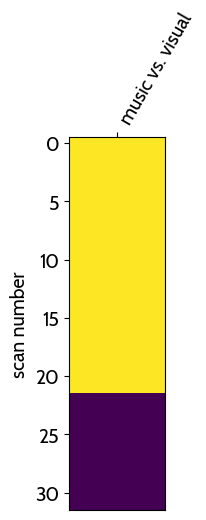

In [6]:
unpaired_design_matrix = pd.DataFrame(
    condition_effect[:, np.newaxis], columns=["music vs. visual"]
)

plotting.plot_design_matrix(
    unpaired_design_matrix, rescale=False
)

In [7]:
from nilearn.glm.second_level import SecondLevelModel
from nilearn.image import resample_to_img

# Resample images to the first image in the list
reference_img = second_level_input[0]
resampled_second_level_input = [resample_to_img(img, reference_img, interpolation='nearest') for img in second_level_input]

# Fit the second-level model with resampled images
second_level_model_unpaired = SecondLevelModel(n_jobs=2, smoothing_fwhm=8).fit(
    resampled_second_level_input, design_matrix=unpaired_design_matrix
)

stat_maps_unpaired = second_level_model_unpaired.compute_contrast(
    "music vs. visual", output_type="all"
)

Threshold: 4.556522982784475


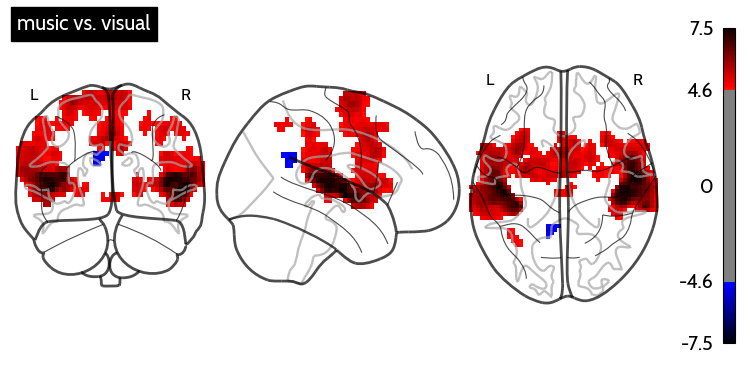

In [40]:
from nilearn.glm import threshold_stats_img

alpha = 0.0001
hc = 'fdr'
ct = 10

corrected_map, thres = threshold_stats_img(stat_maps_unpaired["z_score"], 
                                           cluster_threshold=ct, 
                                           alpha=alpha, 
                                           height_control=hc)

print(f"Threshold: {thres}")

display = plotting.plot_glass_brain(
    corrected_map,
    threshold=thres,
    colorbar=True,
    plot_abs=False,
    title="music vs. visual",
)

Music vs. Visual | Imagery | fdr(0.0001) | k>10


/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



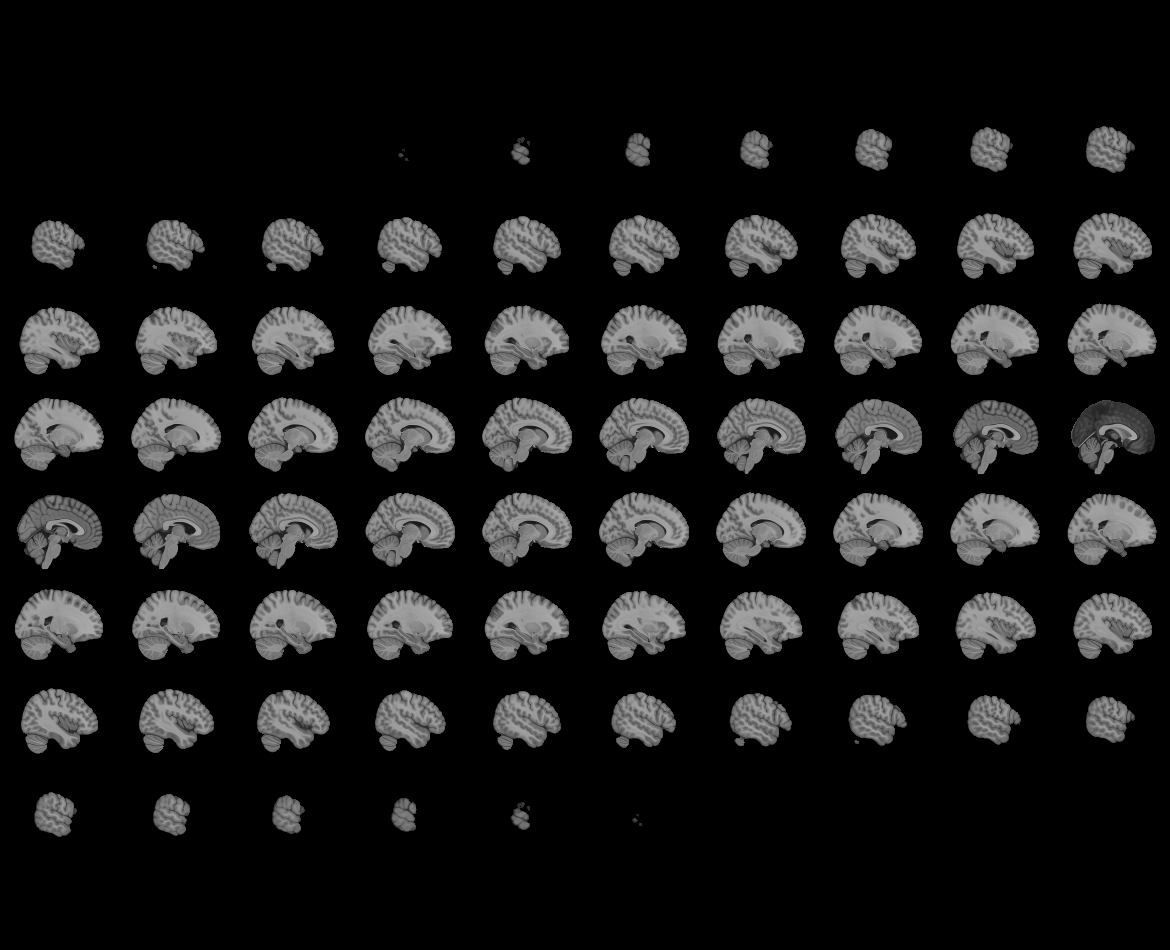
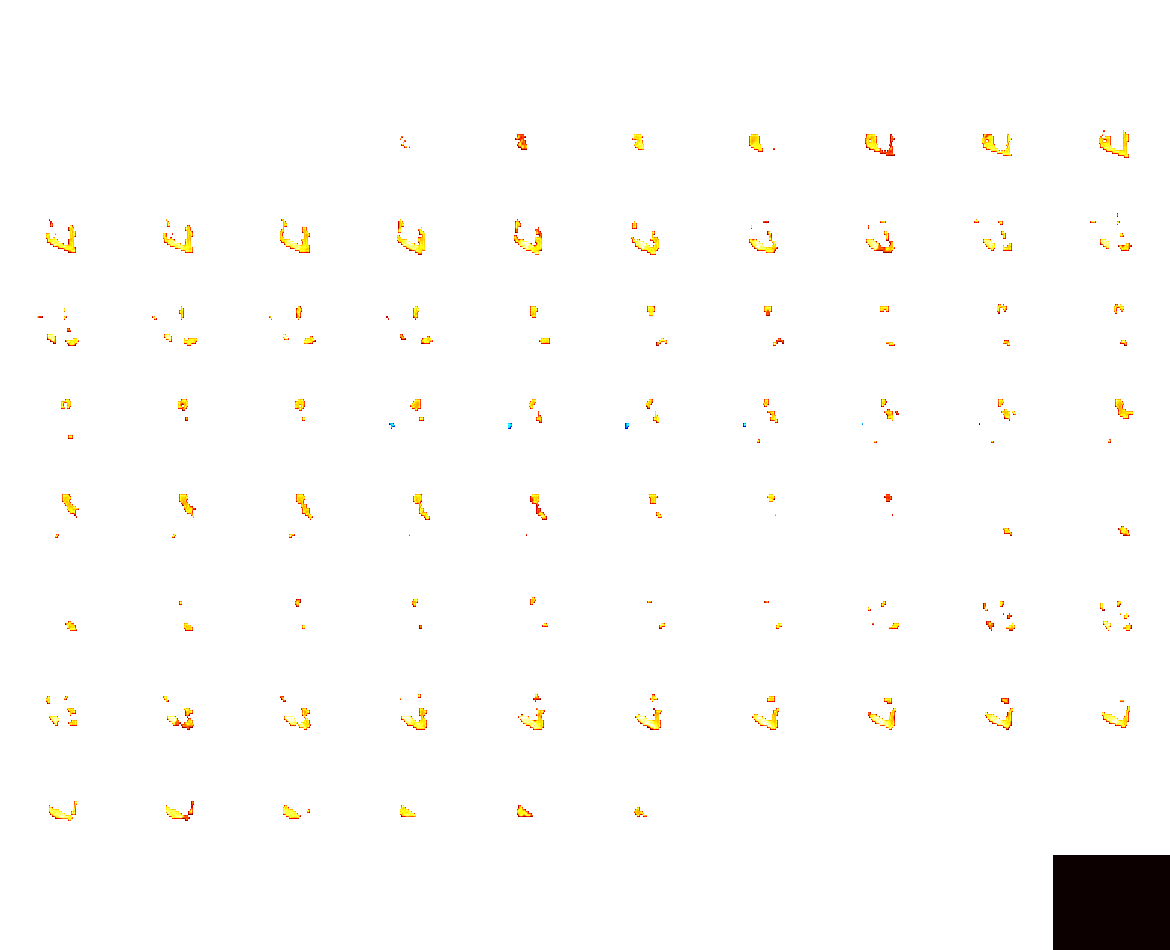

In [41]:
#| label: fig-musicVSvisual-glm-map
print(f"Music vs. Visual | Imagery | {hc}({alpha}) | k>{ct}")
plotting.view_img(corrected_map, threshold=thres, colorbar=True)

In [42]:
#| label: tab-musicVSvisual-glm-clusters
# cluster table
from nilearn.reporting import get_clusters_table
from mni_to_atlas import AtlasBrowser
atlas = AtlasBrowser("AAL3")

table = get_clusters_table(stat_maps_unpaired["z_score"], thres, cluster_threshold=ct)

# AAL3 labelling
coordinates = table[['X','Y','Z']].to_numpy()
aal_labels = atlas.find_regions(coordinates, plot=False)
table['AAL3'] = aal_labels
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),AAL3
0,1,54.0,-9.0,-2.19,7.480039,29518,Temporal_Sup_R
1,1a,45.0,-21.0,5.79,7.316320,,Heschl_R
2,1b,63.0,-33.0,13.77,6.836551,,Temporal_Sup_R
3,1c,36.0,18.0,5.79,5.410875,,Insula_R
4,2,-45.0,-21.0,5.79,7.318895,40398,Temporal_Sup_L
5,2a,-36.0,-30.0,9.78,7.015730,,Heschl_L
6,2b,-54.0,-6.0,1.80,6.501726,,Temporal_Sup_L
7,2c,-36.0,9.0,1.80,6.027723,,Insula_L
8,3,-30.0,-3.0,69.63,5.845064,21617,Frontal_Sup_2_L
9,3a,0.0,9.0,45.69,5.744198,,Supp_Motor_Area_L
